# Introduction

Main goal of this project is create machine/deep learning model and train it to classify motor imagery of human using eeg data from electrodes on person's scalp. This work have got ideas from article https://www.frontiersin.org/articles/10.3389/fnins.2021.655599/full

Large eeg dataset is using at this work. Dataset overview can be found here https://www.researchgate.net/publication/328328921_A_large_electroencephalographic_motor_imagery_dataset_for_electroencephalographic_brain_computer_interfaces
In breaf, participants imagine one of 5 motor action or do not imagine, so here 6 classes. 

Idea of this work is extract features from signal using Morlet Wavelet and Short-Term Fourier transforms (MWT and STFT) and give thoose features to fully-connected convolution net. So firstly STFTConvNet was trained, then MWT was trained and then it was united and MWSTFTNet was trained. Main problem was overfitting, dropout, elastic regularisation and most important - simplifying and parametres reduction were used.

# Data preparision

In [1]:
import numpy as np
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
import gc

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import stft
import pywt
from scipy.signal import decimate

In [2]:
path_to_serialized = './Large EEG dataset/serialized-datasets/'
data_train = np.load(path_to_serialized + 'data_train.npy')
data_test = np.load(path_to_serialized + 'data_test.npy')
data_valid = np.load(path_to_serialized + 'data_valid.npy')

markers_train = np.load(path_to_serialized + 'markers_train.npy')
markers_test = np.load(path_to_serialized + 'markers_test.npy')
markers_valid = np.load(path_to_serialized + 'markers_valid.npy')

In [3]:
# Try to open mat file
mat = scipy.io.loadmat('./Large EEG dataset/HaLTSubjectA1602236StLRHandLegTongue.mat')

In [4]:
print('Each file contains:', mat['o'][0].dtype)
print('Number of points:', mat['o'][0][0][3])
print('Sampling frequency: ', mat['o'][0][0][2])
sampling_rate = mat['o'][0][0][2][0][0]
channels = mat['o'][0][0][6]
number_of_channels = channels.size
channels = np.concatenate(np.reshape(channels, (-1)))
print('Channels order: ', channels)

Each file contains: [('id', 'O'), ('tag', 'O'), ('sampFreq', 'O'), ('nS', 'O'), ('marker', 'O'), ('data', 'O'), ('chnames', 'O'), ('binsuV', 'O')]
Number of points: [[667600]]
Sampling frequency:  [[200]]
Channels order:  ['Fp1' 'Fp2' 'F3' 'F4' 'C3' 'C4' 'P3' 'P4' 'O1' 'O2' 'A1' 'A2' 'F7' 'F8'
 'T3' 'T4' 'T5' 'T6' 'Fz' 'Cz' 'Pz' 'X5']


In [5]:
# Constanst and params declaration
imagery_actions = ['left hand', 'right hand', 'passive', 'left leg', 'tongue', 'right leg']
numpy_dtype = np.float32
sampling_rate = mat['o'][0][0][2][0][0] # 200
channels = np.concatenate(np.reshape(mat['o'][0][0][6], (-1)))
number_of_channels = channels.size
path_to_feature_extracted = './Large EEG dataset/serialized-datasets/feature-extracted/'

## Data union

The marker codes from 1 to 6 encode the visual stimuli directing the participants to implement given mental imageries in the order 1: “left hand,” 2: “right hand,” 3: “passive or neutral,” 4: “left leg,” 5: “tongue,” and 6:“right leg”. Code “0” means “blank” or nothing is displayed in eGUI.
Codes greater than 10 indicate service periods including 99: “initial relaxation,” 91: “intersession breaks,” 92: “experiment end.”

In [220]:
markers = mat['o'][0][0][4]
markers = np.reshape(markers, (-1))
print('Unique values: ', np.unique(markers))

Unique values:  [ 0  1  2  3  4  5  6 91 92 99]


For the analysis of the included data, the times when the “marker” value switched from 0 to a non-zero
value in 1 and 6 can be treated as the action signal onset times

In [221]:
differences = np.diff(markers)
# lh means left hand, rh means right hand and so on
indices_lh = np.where(differences == 1)[0] + 1
indices_rh = np.where(differences == 2)[0] + 1
indices_passive = np.where(differences == 3)[0] + 1
indices_ll = np.where(differences == 4)[0] + 1
indices_t = np.where(differences == 5)[0] + 1
indices_rl = np.where(differences == 6)[0] + 1
print('lh count: ', np.count_nonzero(indices_lh), ', rh count: ', np.count_nonzero(indices_rh), 
      ', passive count: ', np.count_nonzero(indices_passive), ', tongue count: ', np.count_nonzero(indices_t))

lh count:  163 , rh count:  158 , passive count:  158 , tongue count:  171


In [222]:
eeg_data = mat['o'][0][0][5]

The action signal remained on  screen for 1 s, during which time the participants implemented the indicated mental imagery once. A pause of variable duration of 1.5-2.5 s followed, concluding the trial. So event duration = sampling rate * execution time = 200 * 1 = 200

In [28]:
def create_array_of_sections(indices, event_dur, eeg_data):
    array_of_motions = []
    for index in indices:
        if index + event_dur <= len(eeg_data):
            array_of_motions.append(eeg_data[index:index+event_dur])
    return np.array(array_of_motions)

In [224]:
event_duration = sampling_rate

# left hand imaginary motions
lh_im = create_array_of_sections(indices_lh, event_duration, eeg_data)
rh_im = create_array_of_sections(indices_rh, event_duration, eeg_data)
passive_im = create_array_of_sections(indices_passive, event_duration, eeg_data)
ll_im = create_array_of_sections(indices_ll, event_duration, eeg_data)
t_im = create_array_of_sections(indices_t, event_duration, eeg_data)
rl_im = create_array_of_sections(indices_rl, event_duration, eeg_data)


print('Shape of lh_im', lh_im.shape, ' it means 163 left hand imaginary movements episodes, each contains '
      + '200 points in 22 channels')

Shape of lh_im (163, 200, 22)  it means 163 left hand imaginary movements episodes, each contains 200 points in 22 channels


Visualisation of single left hand imaginary movement signal

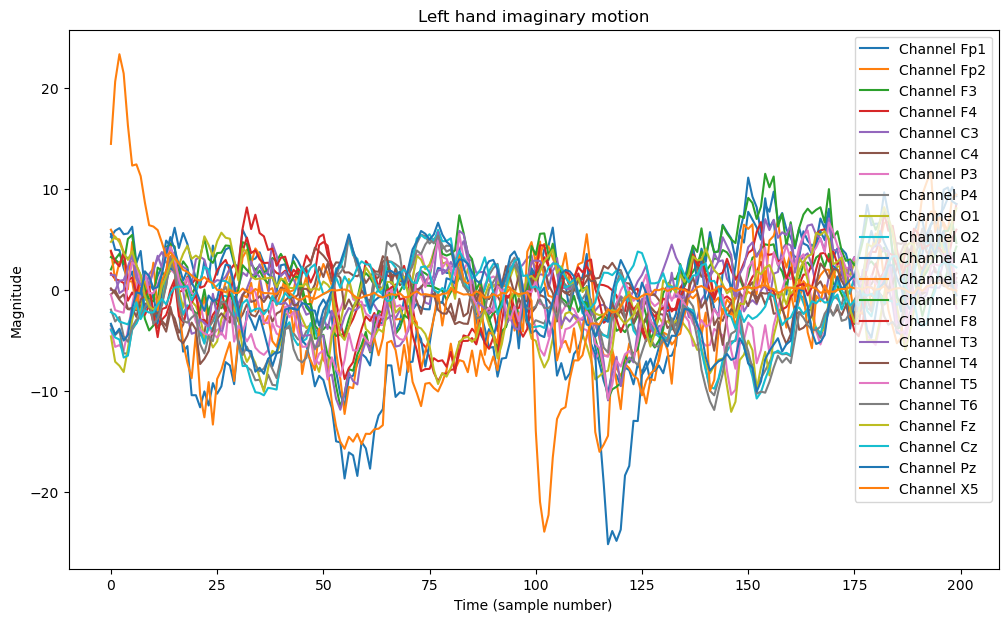

In [60]:
plt.figure(figsize=(12, 7))

number_of_imaginary_action = 50
number_of_channels_to_show = 22
for i in range(number_of_channels_to_show):
    plt.plot(lh_im[number_of_imaginary_action][:, i], label=f'Channel {channels[i]}')

plt.title('Left hand imaginary motion')
plt.xlabel('Time (sample number)')
plt.ylabel('Magnitude')
plt.legend(loc='upper right')

plt.show()

In [61]:
arrays_list = [lh_im, rh_im, passive_im, ll_im, t_im, rl_im]
markers = np.concatenate([np.full(len(arr), i+1) for i, arr in enumerate(arrays_list)])
data = np.concatenate(arrays_list, axis=0)

In [62]:
print('Check for correspondence')
for i, arr in enumerate(arrays_list):
    print(markers[markers == i + 1].size == arr.shape[0])
print(markers.size,'trials in total')

Check for correspondence
True
True
True
True
True
True
959 trials in total


In [63]:
print('EEG signal: ',data[100])
print('Corresponding imagination: ', markers[100])

EEG signal:  [[-13.47 -11.3   -4.7  ...   3.67  -2.63  15.23]
 [-15.75 -12.66  -5.72 ...   2.35  -4.62  21.09]
 [-20.01 -14.24  -8.79 ...   0.68  -3.94  22.99]
 ...
 [-21.7  -21.79  -4.74 ...   1.72   4.58   0.41]
 [-19.64 -19.08  -2.67 ...   1.98   3.12  -0.18]
 [-14.91 -15.    -1.   ...   1.63   1.66  -0.23]]
Corresponding imagination:  1


So we get all imaginary motions from one record. Let's do function that will create array of all motion imaginary from one file.

In [26]:
def cut_all_imaginary_motion(path):
    mat = scipy.io.loadmat(path)
    markers = mat['o'][0][0][4]
    markers = np.reshape(markers, (-1))
    
    differences = np.diff(markers)
    # lh means left hand, rh means right hand and so on
    indices_lh = np.where(differences == 1)[0] + 1
    indices_rh = np.where(differences == 2)[0] + 1
    indices_passive = np.where(differences == 3)[0] + 1
    indices_ll = np.where(differences == 4)[0] + 1
    indices_t = np.where(differences == 5)[0] + 1
    indices_rl = np.where(differences == 6)[0] + 1
    
    eeg_data = mat['o'][0][0][5]
    
    lh_im = create_array_of_sections(indices_lh, event_duration, eeg_data)
    rh_im = create_array_of_sections(indices_rh, event_duration, eeg_data)
    passive_im = create_array_of_sections(indices_passive, event_duration, eeg_data)
    ll_im = create_array_of_sections(indices_ll, event_duration, eeg_data)
    t_im = create_array_of_sections(indices_t, event_duration, eeg_data)
    rl_im = create_array_of_sections(indices_rl, event_duration, eeg_data)
    
    arrays_list = [lh_im, rh_im, passive_im, ll_im, t_im, rl_im]
    markers = np.concatenate([np.full(len(arr), i+1) for i, arr in enumerate(arrays_list)])
    data = np.concatenate(arrays_list, axis=0)
    
    return data, markers

Creating array of all eeg data

In [172]:
directory_path = './Large EEG dataset/'
entries = os.listdir(directory_path)

all_data = []
all_markers = []
for entry in entries:
    full_path = os.path.join(directory_path, entry)
    if os.path.isfile(full_path):
        if '.mat' in full_path:
            data, markers = cut_all_imaginary_motion(full_path)
            all_data.append(data)
            all_markers.append(markers)
            
data = np.concatenate(all_data, axis=0)
markers = np.concatenate(all_markers, axis=0)
del all_data
del all_markers

In [173]:
if data.shape[0] == markers.size:
    print('Dimensions are corresponding:', data.shape[0], 'imaginations in total')

Dimensions are corresponding: 27641 imaginations in total


Firstly I want to transpose data array so firstly will go channels dimension and then time samples (change shape to = (N, 22, 200))

In [174]:
print('Dataset shape before transpose: ', data.shape)
data = np.transpose(data, (0, 2, 1))
print('Dataset shape after transpose: ', data.shape)

Dataset shape before transpose:  (27641, 200, 22)
Dataset shape after transpose:  (27641, 22, 200)


Now shuffle all data and divide into train, test and validation sets

In [175]:
train_size = 0.8
test_size = 0.1
valid_size = 0.1

data_train, data_temp, markers_train, markers_temp = train_test_split(
    data, markers, train_size=train_size, stratify=markers, random_state=42)

data_test, data_valid, markers_test, markers_valid = train_test_split(
    data_temp, markers_temp, test_size=valid_size/(test_size + valid_size), stratify=markers_temp, random_state=42)

print("Size of train dataset:", len(data_train))
print("Size of test dataset:", len(data_test))
print("Size of valid dataset:", len(data_valid))

Size of train dataset: 22112
Size of test dataset: 2764
Size of valid dataset: 2765


### Data normalization

I do data normalization after train, test, val splitting because I don't wanna get data leak.

In [201]:
# Calculation means and stds for every channel
means = np.mean(data_train, axis=(0, 2), keepdims=True)
stds = np.std(data_train, axis=(0, 2), keepdims=True)

In [203]:
data_train = (data_train - means) / stds
data_test = (data_test - means) / stds
data_valid = (data_valid - means) / stds

In [208]:
means_after_normalisation = np.mean(data_train, axis=(0, 2))
stds_after_normalisation = np.std(data_train, axis=(0, 2))

In [210]:
print('Squared sum of means after normalisation (should be equals to zero)', np.sum(means_after_normalisation**2))
print('Squared sum of stds after normalisation divided to channels number (should be equals to one)', 
      np.sum(stds_after_normalisation**2) / number_of_channels)

Squared sum of means after normalisation (should be equals to zero) 4.333208755311453e-28
Squared sum of stds after normalisation divided to channels number (should be equals to one) 1.000000000000079


Calculate those sums for data test and data valid:

In [212]:
means_after_test = np.mean(data_test, axis=(0, 2))
stds_after_test = np.std(data_test, axis=(0, 2))
print('Squared sum of means and stds / channels num for test', np.sum(means_after_test**2), 
     np.sum(stds_after_test**2) / number_of_channels)

means_after_valid = np.mean(data_valid, axis=(0, 2))
stds_after_valid = np.std(data_valid, axis=(0, 2))
print('Squared sum of means and stds / channels num for valid', np.sum(means_after_valid**2), 
     np.sum(stds_after_valid**2) / number_of_channels)

Squared sum of means and stds / channels num for test 0.007527724394062519 1.054971420267394
Squared sum of means and stds / channels num for valid 0.0030835513623783746 0.8943016739774285


Frankly speaking, equalities are not satisfie, but they are close, so we blind eye to these things.

Serialize train, test and valid dataset for skipping all above actions in future

In [213]:
path_to_serialized = './Large EEG dataset/serialized-datasets/'

In [214]:
np.save(path_to_serialized + 'data_train.npy', data_train)
np.save(path_to_serialized + 'data_test.npy', data_test)
np.save(path_to_serialized + 'data_valid.npy', data_valid)

np.save(path_to_serialized + 'markers_train.npy', markers_train)
np.save(path_to_serialized + 'markers_test.npy', markers_test)
np.save(path_to_serialized + 'markers_valid.npy', markers_valid)

Visualisation of data after all stuff above

In [234]:
def visualize_sample(sample, marker=None, channels_to_show=None):
    plt.figure(figsize=(12, 7))
    if channels_to_show is None:
        for i in range(number_of_channels):
            plt.plot(sample[i, :], label=f'Channel {channels[i]}')
    else:
        for i in range(channels_to_show):
            plt.plot(sample[i, :], label=f'Channel {channels[i]}')
    if marker is not None:
        plt.title(str(imagery_actions[marker]))
    plt.xlabel('Time (sample number)')
    plt.ylabel('Magnitude')
    plt.legend(loc='upper right')

    plt.show()

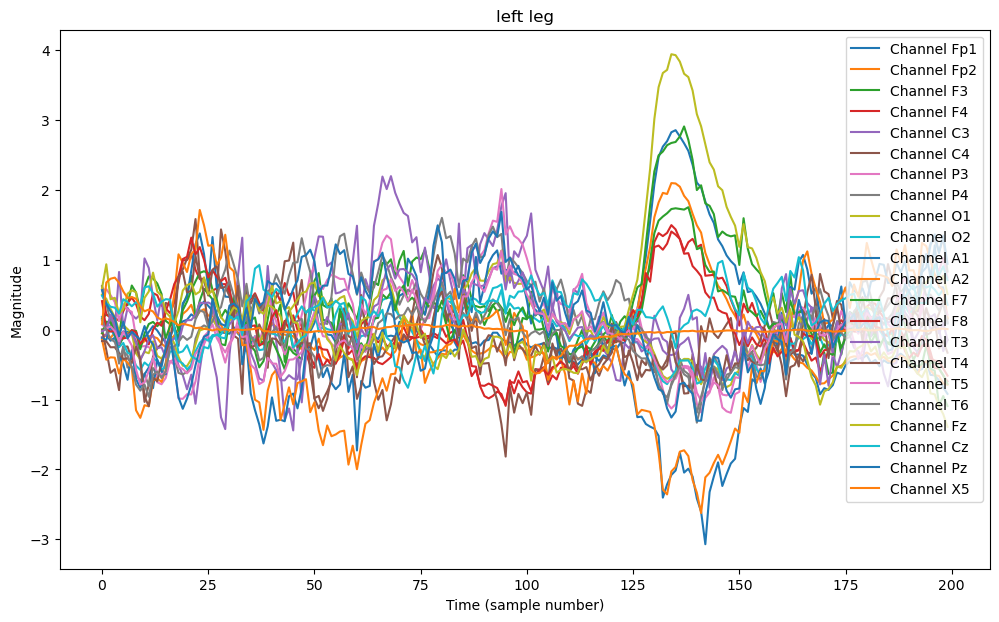

In [235]:
number_of_imaginary_action = 5000
number_of_channels_to_show = 22
visualize_sample(data_train[number_of_imaginary_action], markers_train[number_of_imaginary_action])

# Machine learning

In [9]:
path_to_serialized = './Large EEG dataset/serialized-datasets/'
data_train = np.load(path_to_serialized + 'data_train.npy')
data_test = np.load(path_to_serialized + 'data_test.npy')
data_valid = np.load(path_to_serialized + 'data_valid.npy')

markers_train = np.load(path_to_serialized + 'markers_train.npy')
markers_test = np.load(path_to_serialized + 'markers_test.npy')
markers_valid = np.load(path_to_serialized + 'markers_valid.npy')

### Regression
Why not, firstly try the most simple model

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np

In [91]:
data_train_logistic = data_train.reshape((data_train.shape[0], -1))
data_test_logistic = data_test.reshape((data_test.shape[0], -1))

In [119]:
# Creating logistic regression model
logistic_model = LogisticRegression(max_iter=1000, random_state=42)
logistic_model.fit(data_train_logistic, markers_train)

# Predictions
predicted_labels = logistic_model.predict(data_test_logistic)

# Calculate metrics
accuracy = accuracy_score(markers_test, predicted_labels)
conf_matrix = confusion_matrix(markers_test, predicted_labels)
classification_rep = classification_report(markers_test, predicted_labels)

# Results
print("Accuracy:", accuracy)
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", classification_rep)

Accuracy: 0.17040520984081042

Confusion Matrix:
 [[ 69  71  79  84  76  84]
 [ 67  77  79  75  82  79]
 [ 73  65  89  68  85  76]
 [ 97  66  72  77  70  74]
 [ 70 100  79  79  81  76]
 [ 79  72  56  78  82  78]]

Classification Report:
               precision    recall  f1-score   support

           1       0.15      0.15      0.15       463
           2       0.17      0.17      0.17       459
           3       0.20      0.20      0.20       456
           4       0.17      0.17      0.17       456
           5       0.17      0.17      0.17       485
           6       0.17      0.18      0.17       445

    accuracy                           0.17      2764
   macro avg       0.17      0.17      0.17      2764
weighted avg       0.17      0.17      0.17      2764



As we can see simple machine learning methods without feature extraction works bad at raw eeg data

# Feature extraction

Short-Term Fourier Transform and Morlet Wavelet Transform is good feature extraction methods because they works in temporal-frequency domain.

In [102]:
some_number = 1337
signal = data_train[some_number][13]

## Short Term Fourier Transform 

In order to effectively measure the change trend of the µ rhythm and β rhythm in the signal, this paper selects the time-frequency matrix obtained by the time window of 0.5s and the hamming window function

In [6]:
STFT_freq_num = 50
STFT_length = STFT_freq_num * 2 - 1
STFT_time_num = 40
signal_len = 200
STFT_overlap = int(abs((signal_len - STFT_time_num*(STFT_length-1))/(STFT_time_num-1))) - 1 # Don't know if it work
def STFT(signal, sampling_rate=200, segm_length=STFT_length, noverlap=STFT_overlap): # signal (22, 200) -> (22, N_freq, N_segm)
    # nperseg - lenght of each segm
    # noverlap - Number of points to overlap between segments. If None, noverlap = nperseg // 2.
    # Defaults to a Hann window so we change to hamming
    if type(signal) == torch.tensor:
        signal = signal.numpy()
    frequencies, times, magnitude = stft(signal, fs=sampling_rate, nperseg=segm_length, 
                                         window='hamming', noverlap=noverlap)
    return frequencies, times, magnitude

Get some signal and try to perform STFT.

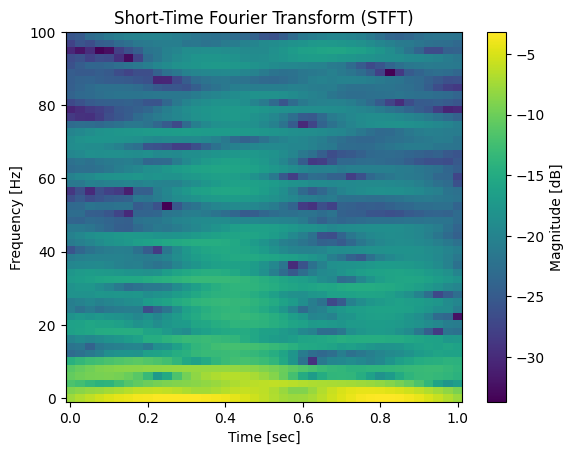

In [118]:
frequencies, times, stft_magnitude = STFT(signal)
plt.pcolormesh(times, frequencies, 10 * np.log10(np.abs(stft_magnitude)))
plt.title('Short-Time Fourier Transform (STFT)')
plt.xlabel('Time [sec]')
plt.ylabel('Frequency [Hz]')
plt.colorbar(label='Magnitude [dB]')
plt.show()

## Morlet Wavelet Transform

In [135]:
signals = data_train[100:103]
magn, freq = MorletTransform(signals)

In [7]:
# def MorletTransform(signal, freq=np.arange(1, 31), wavelet='morl', sampling_rate=200, axis=-1):
#     scale = pywt.frequency2scale('morl', freq)
#     # Morlet Wavelet Transform
#     cwt_result, frequencies = pywt.cwt(signal, freq, wavelet, sampling_rate, axis=axis)
#     return cwt_result, frequencies
wavelet = 'morl'
def MorletTransform(signal, freq=np.arange(1, 51), wavelet=wavelet, sampling_rate=200):
    scales = pywt.frequency2scale(wavelet, freq / sampling_rate)
    if type(signal) == torch.Tensor:
        signal = signal.numpy()
    cwt_result, frequencies = pywt.cwt(signal, scales, wavelet)
    cwt_result = cwt_result.astype(numpy_dtype)
    if len(cwt_result.shape) == 4:
        cwt_result = cwt_result.transpose(1, 2, 0, 3)
    return cwt_result, frequencies

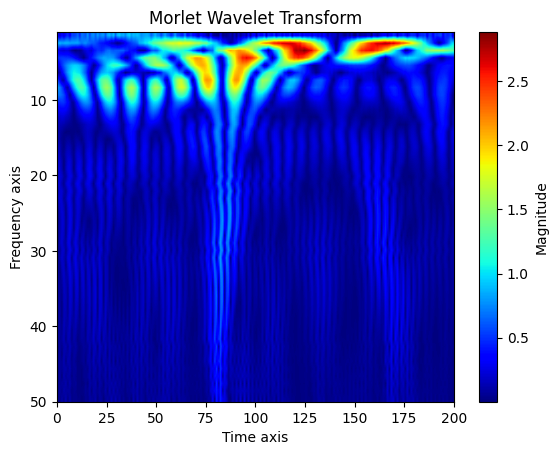

In [134]:
mt_magnitude, frequencies = MorletTransform(signal)
frequencies*=sampling_rate

plt.imshow(np.abs(mt_magnitude), aspect='auto', extent=[0, 200, frequencies[-1], frequencies[0]], cmap='jet', interpolation='bilinear')
plt.colorbar(label='Magnitude')
plt.title('Morlet Wavelet Transform')
plt.xlabel('Time axis')
plt.ylabel('Frequency axis')
plt.show()

In [355]:
print('Shape of STFT output (one channel)', stft_magnitude.shape)
print('Shape of MT output (one channel)', mt_magnitude.shape)

Shape of STFT output (one channel) (51, 21)
Shape of MT output (one channel) (50, 200)


# Logistic regression with feature extraction

## Feature extraction of datasets

In [75]:
def split_apply_combine_stft(data, chunk_size=100, noverlap=80):
    chunks=[]
    for i in range(0, data.shape[0], chunk_size):
        chunks.append(data[i:i+chunk_size,:,:])
    stft_results = [STFT(chunk, noverlap=noverlap)[2] for chunk in chunks]
    result = np.concatenate(stft_results)
    return result

In [76]:
def split_apply_combine_mt(data, chunk_size=100):
    chunks=[]
    for i in range(0, data.shape[0], chunk_size):
        chunks.append(data[i:i+chunk_size,:,:])
    mt_results = [MorletTransform(chunk)[0].transpose(1, 2, 0, 3) for chunk in chunks]
    result = np.concatenate(mt_results)
    return result

After performing STFT data has complex datatype. Find just magnitude.

In [9]:
path_to_feature_extracted = './Large EEG dataset/serialized-datasets/feature-extracted/'

In [10]:
data_train_stft = split_apply_combine_stft(data_train, noverlap=80)
data_train_stft = np.abs(data_train_stft)
print('shape of tensor: ', data_train_stft.shape)
np.save(path_to_feature_extracted + 'data_train_stft.npy', data_train_stft)

shape of tensor:  (22112, 22, 51, 11)


In [11]:
data_test_stft = split_apply_combine_stft(data_test, noverlap=80)
data_test_stft = np.abs(data_test_stft)
np.save(path_to_feature_extracted + 'data_test_stft.npy', data_test_stft)

In [12]:
path_to_feature_extracted = './Large EEG dataset/serialized-datasets/feature-extracted/'

In [13]:
data_train_stft = np.load(path_to_feature_extracted + 'data_train_stft.npy')
data_test_stft = np.load(path_to_feature_extracted + 'data_test_stft.npy')

## Train model

Data loading and preparing

In [8]:
path_to_serialized = './Large EEG dataset/serialized-datasets/'
path_to_feature_extracted = './Large EEG dataset/serialized-datasets/feature-extracted/'

data_train_logistic = np.load(path_to_feature_extracted + 'data_train_stft.npy')
data_test_logistic = np.load(path_to_feature_extracted + 'data_test_stft.npy')

In [12]:
data_train_logistic = data_train_logistic.reshape((data_train.shape[0], -1))
data_test_logistic = data_test_logistic.reshape((data_test.shape[0], -1))

Training

In [13]:
# Creating logistic regression model
logistic_model = LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1)
logistic_model.fit(data_train_logistic, markers_train)

# Predictions
predicted_labels = logistic_model.predict(data_test_logistic)

# Calculate metrics
accuracy = accuracy_score(markers_test, predicted_labels)
conf_matrix = confusion_matrix(markers_test, predicted_labels)
classification_rep = classification_report(markers_test, predicted_labels)

# Results
print("Accuracy:", accuracy)
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", classification_rep)

Accuracy: 0.5723589001447178

Confusion Matrix:
 [[239  53  51  56  37  27]
 [ 48 239  60  21  66  25]
 [ 56  62 246  34  25  33]
 [ 60  27  29 263  53  24]
 [ 17  63  38  40 300  27]
 [ 38  30  31  30  21 295]]

Classification Report:
               precision    recall  f1-score   support

           1       0.52      0.52      0.52       463
           2       0.50      0.52      0.51       459
           3       0.54      0.54      0.54       456
           4       0.59      0.58      0.58       456
           5       0.60      0.62      0.61       485
           6       0.68      0.66      0.67       445

    accuracy                           0.57      2764
   macro avg       0.57      0.57      0.57      2764
weighted avg       0.57      0.57      0.57      2764



/home/zachar/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuraccy of model: 0.57

Got something (accuracy ~ 0.5). Just use stft.

# Neural Network

## STFT Conv net

Start with STFT net

In [8]:
import numpy as np
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import os
import gc
import copy

from scipy.signal import stft
import pywt
from scipy.signal import decimate
from torch.optim import lr_scheduler

import torch
from torchvision import datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data import Dataset
import torch

path_to_serialized = './Large EEG dataset/serialized-datasets/'
torch.cuda.empty_cache() 
gc.collect()

dtype = torch.float32

if 'data_train' not in locals():
    data_train = np.load(path_to_serialized + 'data_train.npy')
if 'data_test' not in locals():
    data_test = np.load(path_to_serialized + 'data_test.npy')
if 'data_val' not in locals():
    data_val = np.load(path_to_serialized + 'data_valid.npy')

if 'markers_train' not in locals():
    markers_train = np.load(path_to_serialized + 'markers_train.npy')
if 'markers_test' not in locals():
    markers_test = np.load(path_to_serialized + 'markers_test.npy')
if 'markers_val' not in locals():
    markers_val = np.load(path_to_serialized + 'markers_valid.npy')

if torch.cuda.is_available:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [9]:
class TinySTFTConvExtractor(nn.Module):
    def __init__(self, dropout=0.0):
        super().__init__()
        # Time-convolutions
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=48, kernel_size=(1,21), padding=(0,10)),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        self.batch_norm1 = nn.BatchNorm1d(num_features=41)
        self.pool1 = nn.MaxPool2d(kernel_size=(1, 2), stride=(1, 2))
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=48, out_channels=56, kernel_size=(1,11), padding=(0,5)),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        self.batch_norm2 = nn.BatchNorm1d(num_features=20)
        self.pool2 = nn.MaxPool2d(kernel_size=(1, 2), stride=(1, 2))

        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=56, out_channels=64, kernel_size=(1,5), padding=(0,2)),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        self.batch_norm3 = nn.BatchNorm1d(num_features=10)
        
        # Freq convolution
        self.freq_conv = nn.Sequential(
            nn.Conv2d(in_channels=22, out_channels=32, kernel_size=(50,1), padding=(0,0)),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        
    def forward(self, x): # [BatchSize, 22, 51, 41] as input
        x = self.freq_conv(x)
        x = self.batch_norm1(self.conv1(x).view(-1, 41)).view(-1, 48, 1, 41)
        x = self.pool1(x)
        
        x = self.batch_norm2(self.conv2(x).view(-1, 20)).view(-1, 56, 1, 20)
        x = self.pool2(x)

        x = self.batch_norm3(self.conv3(x).view(-1, 10)).view(-1, 64, 1, 10)

        return x.view(-1, 64 * 10)

In [10]:
class TinySTFTConvNet(nn.Module):
    def __init__(self, name, dropout=0.0):
        super().__init__()
        self.name = name
        self.best_accuracy = 0
        self.extractor = TinySTFTConvExtractor(dropout=dropout)
        self.classifier = nn.Sequential(
            nn.Linear(64 * 10, 100),
            nn.ELU(),
            nn.Dropout(dropout),
            nn.BatchNorm1d(100),
            nn.Linear(100, 6),
            nn.Softmax(dim=1),
        )
    
    def forward(self, x):
        x = torch.from_numpy(np.abs(STFT(x.to('cpu'))[2])).to(dtype).to(device)
        x = self.extractor(x)
        x = self.classifier(x)
        return x

In [106]:
class STFTConvExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        # Time-convolutions
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=22, out_channels=128, kernel_size=(1,21), padding=(0,10)),
            nn.ReLU()
        )
        self.batch_norm1 = nn.BatchNorm1d(num_features=41)

        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(1,21), padding=(0,10)),
            nn.ReLU()
        )
        self.batch_norm2 = nn.BatchNorm1d(num_features=41)
        self.pool1 = nn.MaxPool2d(kernel_size=(1, 2), stride=(1, 2))
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(1,11), padding=(0,5)),
            nn.ReLU()
        )
        self.batch_norm3 = nn.BatchNorm1d(num_features=20)
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(1,11), padding=(0,5)),
            nn.ReLU()
        )
        self.batch_norm4 = nn.BatchNorm1d(num_features=20)
        self.pool2 = nn.MaxPool2d(kernel_size=(1, 2), stride=(1, 2))

        
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(1,5), padding=(0,2)),
            nn.ReLU()
        )
        self.batch_norm5 = nn.BatchNorm1d(num_features=10)
        self.conv6 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(1,5), padding=(0,2)),
            nn.ReLU()
        )
        self.batch_norm6 = nn.BatchNorm1d(num_features=10)

        # Freq convolutions
        self.freq_conv = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=128, kernel_size=(50,1), padding=(0,0)),
            nn.ReLU()
        )
        
    def forward(self, x): # [BatchSize, 22, 51, 41] as input
        x = self.batch_norm1(self.conv1(x).view(-1, 41)).view(-1, 128, 50, 41)
        x = self.batch_norm2(self.conv2(x).view(-1, 41)).view(-1, 128, 50, 41)
        x = self.pool1(x)
        
        x = self.batch_norm3(self.conv3(x).view(-1, 20)).view(-1, 256, 50, 20)
        x = self.batch_norm4(self.conv4(x).view(-1, 20)).view(-1, 256, 50, 20)
        x = self.pool2(x)

        x = self.batch_norm5(self.conv5(x).view(-1, 10)).view(-1, 512, 50, 10)
        x = self.batch_norm6(self.conv6(x).view(-1, 10)).view(-1, 512, 50, 10)

        x = self.freq_conv(x)
        return x.view(-1, 128 * 10)

In [107]:
class LightSTFTConvExtractor(nn.Module): #TODO do one extractor with different params (channels num)
    def __init__(self, dropout=0.0):
        super().__init__()
        # Time-convolutions
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=22, out_channels=32, kernel_size=(1,21), padding=(0,10)),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        self.batch_norm1 = nn.BatchNorm1d(num_features=41)

        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(1,21), padding=(0,10)),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        self.batch_norm2 = nn.BatchNorm1d(num_features=41)
        self.pool1 = nn.MaxPool2d(kernel_size=(1, 2), stride=(1, 2))
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(1,11), padding=(0,5)),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        self.batch_norm3 = nn.BatchNorm1d(num_features=20)
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(1,11), padding=(0,5)),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        self.batch_norm4 = nn.BatchNorm1d(num_features=20)
        self.pool2 = nn.MaxPool2d(kernel_size=(1, 2), stride=(1, 2))

        
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(1,5), padding=(0,2)),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        self.batch_norm5 = nn.BatchNorm1d(num_features=10)
        self.conv6 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(1,5), padding=(0,2)),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        self.batch_norm6 = nn.BatchNorm1d(num_features=10)

        # Freq convolutions
        self.freq_conv = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(50,1), padding=(0,0)),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        
    def forward(self, x): # [BatchSize, 22, 51, 41] as input
        x = self.batch_norm1(self.conv1(x).view(-1, 41)).view(-1, 32, 50, 41)
        x = self.batch_norm2(self.conv2(x).view(-1, 41)).view(-1, 32, 50, 41)
        x = self.pool1(x)
        
        x = self.batch_norm3(self.conv3(x).view(-1, 20)).view(-1, 64, 50, 20)
        x = self.batch_norm4(self.conv4(x).view(-1, 20)).view(-1, 64, 50, 20)
        x = self.pool2(x)

        x = self.batch_norm5(self.conv5(x).view(-1, 10)).view(-1, 128, 50, 10)
        x = self.batch_norm6(self.conv6(x).view(-1, 10)).view(-1, 128, 50, 10)

        x = self.freq_conv(x)
        return x.view(-1, 128 * 10)

In [108]:
class STFTConvNet(nn.Module):
    def __init__(self, name, dropout=0.0):
        super().__init__()
        self.name = name
        self.best_accuracy = 0
        self.extractor = LightSTFTConvExtractor(dropout=dropout)
        self.classifier = nn.Sequential(
            nn.Linear(1280, 6),
            nn.Softmax(dim=1),
        )
    
    def forward(self, x):
        x = torch.from_numpy(np.abs(STFT(x.to('cpu'))[2])).to(dtype).to(device)
        x = self.extractor(x)
        x = self.classifier(x)
        return x

In [21]:
def get_num_of_model_param(model):
    num_param = 0
    for parameter in model.parameters():
        num_param += parameter.numel()
    return num_param

## Train STFT model

Firtsly, create dataset from numpy arrays

In [11]:
def one_hot_encode(arr):
    unique_values = np.unique(arr)
    num_classes = len(unique_values)

    one_hot_tensor = torch.zeros((arr.shape[0], num_classes), dtype=torch.float32)
    
    for i, value in enumerate(arr):
        class_index = np.where(unique_values == value)[0][0]
        one_hot_tensor[i, class_index] = 1.0
    
    return one_hot_tensor

In [12]:
def create_dataloader(numpy_samples, numpy_target, batch_size=64):
    # Do one hot encoding
    if len(numpy_target.shape) == 1:
        torch_target = one_hot_encode(numpy_target).float()
    else:
        torch_target = torch.from_numpy(numpy_target).float()
    torch_samples = torch.from_numpy(numpy_samples).float()
    dataset = TensorDataset(torch_samples, torch_target)
    dataloader = DataLoader(dataset, batch_size)
    return dataloader

In [13]:
batch_size = 64
epochs = 10
class_num = 6
train_loader = create_dataloader(data_train, markers_train, batch_size)
val_loader = create_dataloader(data_val, markers_val, batch_size)
test_loader = create_dataloader(data_test, markers_test, batch_size)

In [73]:
path_to_saved_weights = './saving-weights'
def compute_l1_loss(w):
    return torch.abs(w).sum()  
def compute_l2_loss(w):
    return torch.square(w).sum()
    
def train(model, data_tr, data_val, loss_fn, epochs, optimizer, scheduler=None, 
          l1=0.0, l2=0.0, freeze_moment=None, output=True):
    if output: print('Start training')
    history = {'train': [], 'val': [], 'accuracy': []}
    best_accuracy = 0
    best_model_wts = copy.deepcopy(model.state_dict())
    for epoch in range(epochs):
        # For transfer learning
        if epoch == freeze_moment:
            for param in model.parameters():
                param.requires_grad = False
            for param in model.classifier.parameters():
                param.requires_grad = True
        
        avg_loss = 0
        model.train()
        for X_batch, Y_batch in data_tr:
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)

            optimizer.zero_grad()
            Y_pred = model.forward(X_batch)
            loss = loss_fn(Y_pred, Y_batch)
             
            parameters = []
            for parameter in model.parameters():
                parameters.append(parameter.view(-1))
            l1_loss = l1 * compute_l1_loss(torch.cat(parameters))
            l2_loss = l2 * compute_l2_loss(torch.cat(parameters))
              
            loss += l1_loss
            loss += l2_loss
            
            loss.backward()
            optimizer.step()
            avg_loss += loss.item()

        avg_loss /= len(data_tr)
        history['train'].append(avg_loss)

        model.eval()
        avg_val_loss = 0
        accuracy = 0
        for inputs, labels in data_val:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model.forward(inputs)
            loss = loss_fn(outputs, labels)
            avg_val_loss += loss.item()

            predicted_classes = torch.argmax(outputs, axis=1)
            real_classes = torch.argmax(labels, axis=1)
            correct_predictions = torch.sum(real_classes == predicted_classes)
            total_examples = labels.shape[0]
            accuracy += correct_predictions / total_examples

        avg_val_loss /= len(data_val)
        accuracy /= len(data_val)
        history['val'].append(avg_val_loss)
        history['accuracy'].append(accuracy)
        if output:
            print('%d / %d - val loss: %f, accuracy: %f'  % (epoch + 1, epochs, avg_val_loss, accuracy))

        if epoch == 0 or accuracy > best_accuracy:
            best_accuracy = accuracy
            model.best_accuracy = best_accuracy
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), path_to_saved_weights + '/' + model.name + '.pth')

        if scheduler is not None:
            scheduler.step()

        torch.cuda.empty_cache()
        gc.collect()

    model.load_state_dict(best_model_wts)
    return history

In [15]:
def visualize_history(history):
    plt.plot(history['train'], label='Train Loss')
    plt.plot(history['val'], label='Validation Loss')
    
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    plt.show()

In [74]:
light_stft_model = STFTConvNet('LightSTFT', dropout=0.0)
light_stft_model.extractor = LightSTFTConvExtractor(dropout=0.0)
light_stft_model = light_stft_model.to(device)
optimizer = torch.optim.Adam(light_stft_model.parameters(), lr=4e-5)
sсheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma = 0.1)
loss = nn.BCELoss()

torch.cuda.empty_cache() 
_ = gc.collect()
lightSTFT_history = train(light_stft_model, train_loader, val_loader, loss, epochs, optimizer, sсheduler)

Start training
1 / 10 - val loss: 0.377602, accuracy: 0.434523
2 / 10 - val loss: 0.335969, accuracy: 0.507676
3 / 10 - val loss: 0.318453, accuracy: 0.531113
4 / 10 - val loss: 0.309686, accuracy: 0.552038
5 / 10 - val loss: 0.306225, accuracy: 0.559850
6 / 10 - val loss: 0.306153, accuracy: 0.562664
7 / 10 - val loss: 0.307784, accuracy: 0.565150
8 / 10 - val loss: 0.312838, accuracy: 0.565887
9 / 10 - val loss: 0.319348, accuracy: 0.562691
10 / 10 - val loss: 0.335775, accuracy: 0.555589


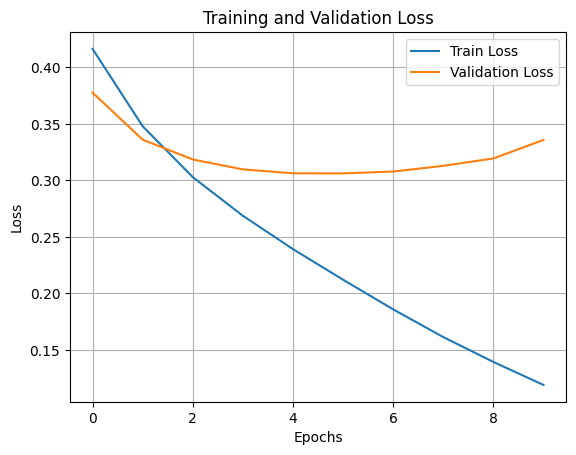

In [75]:
visualize_history(lightSTFT_history)

It seems that after ~5 epoch model starts overfitting proccess. Now try train model with more parameters.

In [24]:
stft_model = STFTConvNet('STFT')
stft_model.extractor = STFTConvExtractor()
stft_model = stft_model.to(device)

optimizer = torch.optim.Adam(stft_model.parameters(), lr=4e-5)
sсheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma = 0.1)
loss = nn.BCELoss()

torch.cuda.empty_cache() 
_ = gc.collect()

In [25]:
STFT_history = train(stft_model, train_loader, val_loader, loss, epochs, optimizer, sсheduler)

Start training
1 / 10 - val loss: 0.337817, accuracy: 0.506938
2 / 10 - val loss: 0.308591, accuracy: 0.558075
3 / 10 - val loss: 0.292565, accuracy: 0.585746
4 / 10 - val loss: 0.286810, accuracy: 0.598558
5 / 10 - val loss: 0.298611, accuracy: 0.614866
6 / 10 - val loss: 0.340214, accuracy: 0.590445
7 / 10 - val loss: 0.353615, accuracy: 0.585091
8 / 10 - val loss: 0.377796, accuracy: 0.580119
9 / 10 - val loss: 0.353838, accuracy: 0.608501
10 / 10 - val loss: 0.388213, accuracy: 0.599623


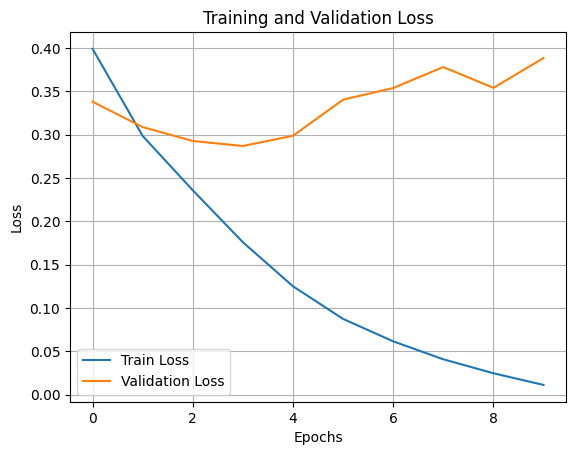

In [26]:
visualize_history(STFT_history)

As we can see overfitting appears and here ~ 4-5 epochs. We can try avoid it. Firstly use dropout.

In [27]:
epochs = 30
dropout_proba = 0.2
light_stft_model_dr = STFTConvNet('LightSTFTDr', dropout=dropout_proba)
light_stft_model_dr.extractor = LightSTFTConvExtractor(dropout=dropout_proba)
light_stft_model_dr = light_stft_model_dr.to(device)
optimizer = torch.optim.Adam(light_stft_model_dr.parameters(), lr=4e-5)
sсheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma = 0.1)
loss = nn.BCELoss()

torch.cuda.empty_cache() 
_ = gc.collect()

In [28]:
light_STFT_dr_history = train(light_stft_model_dr, train_loader, val_loader, loss, epochs, optimizer, sсheduler)

Start training
1 / 30 - val loss: 0.437118, accuracy: 0.219788
2 / 30 - val loss: 0.411309, accuracy: 0.311052
3 / 30 - val loss: 0.401117, accuracy: 0.358583
4 / 30 - val loss: 0.391251, accuracy: 0.398683
5 / 30 - val loss: 0.391560, accuracy: 0.418597
6 / 30 - val loss: 0.377074, accuracy: 0.449465
7 / 30 - val loss: 0.378733, accuracy: 0.454819
8 / 30 - val loss: 0.368429, accuracy: 0.467603
9 / 30 - val loss: 0.357755, accuracy: 0.487107
10 / 30 - val loss: 0.356680, accuracy: 0.490685
11 / 30 - val loss: 0.352567, accuracy: 0.493854
12 / 30 - val loss: 0.348588, accuracy: 0.499180
13 / 30 - val loss: 0.351187, accuracy: 0.493144
14 / 30 - val loss: 0.349100, accuracy: 0.496695
15 / 30 - val loss: 0.349171, accuracy: 0.498470
16 / 30 - val loss: 0.348699, accuracy: 0.502021
17 / 30 - val loss: 0.350371, accuracy: 0.500246
18 / 30 - val loss: 0.348793, accuracy: 0.500246
19 / 30 - val loss: 0.351665, accuracy: 0.501994
20 / 30 - val loss: 0.351244, accuracy: 0.498115
21 / 30 - val 

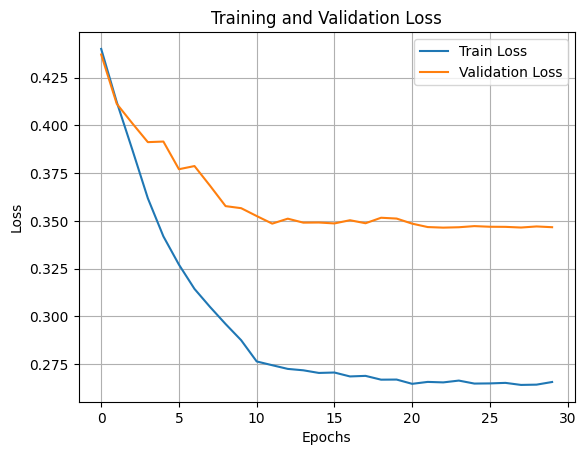

In [29]:
visualize_history(light_STFT_dr_history)

Actually dropout helps to avoid overfitting, but the final quality is worse than without dropout
But we still don't use test set, write function for evaluation of model.

Models appears to be too large and obviously they remember train set and it is cause of overfitting. Now try to write net with fewer number of params to avoid overfitting.

number of model params: 180192
Start training
1 / 18 - val loss: 0.382040, accuracy: 0.414609
2 / 18 - val loss: 0.340376, accuracy: 0.484976
3 / 18 - val loss: 0.315959, accuracy: 0.530813
4 / 18 - val loss: 0.331707, accuracy: 0.506283
5 / 18 - val loss: 0.323578, accuracy: 0.517346
6 / 18 - val loss: 0.292253, accuracy: 0.573399
7 / 18 - val loss: 0.294785, accuracy: 0.578726
8 / 18 - val loss: 0.296053, accuracy: 0.572334
9 / 18 - val loss: 0.297099, accuracy: 0.573399
10 / 18 - val loss: 0.296451, accuracy: 0.575530
11 / 18 - val loss: 0.288024, accuracy: 0.584763
12 / 18 - val loss: 0.286860, accuracy: 0.588314
13 / 18 - val loss: 0.287308, accuracy: 0.589024
14 / 18 - val loss: 0.287460, accuracy: 0.586894
15 / 18 - val loss: 0.288556, accuracy: 0.589024
16 / 18 - val loss: 0.286949, accuracy: 0.588669
17 / 18 - val loss: 0.287325, accuracy: 0.589379
18 / 18 - val loss: 0.287441, accuracy: 0.591155


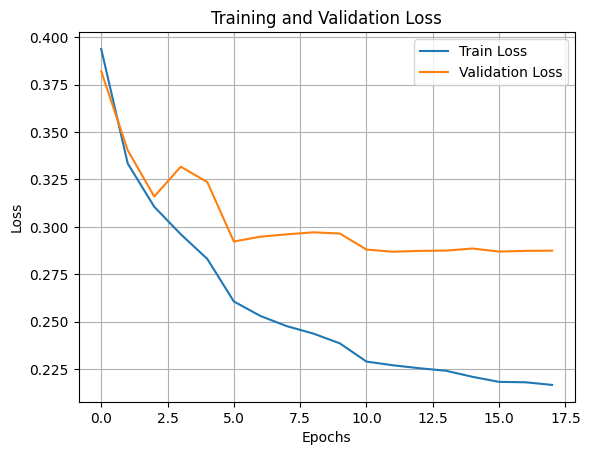

In [160]:
epochs = 18
tiny_stft = TinySTFTConvNet('tinySTFT', dropout=0.1).to(device)

optimizer = torch.optim.Adam(tiny_stft.parameters(), lr=4e-4)
sсheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma = 0.25)
loss = nn.BCELoss()
number_of_param = get_num_of_model_param(tiny_stft)
print('number of model params:', number_of_param)

l1 = 0.1 / number_of_param
l2 = 0.2 / number_of_param
tiny_history = train(tiny_stft, train_loader, val_loader, loss, epochs, optimizer, sсheduler, l1=l1, l2=l2)
visualize_history(tiny_history)

In [24]:
def evaluate_net(model, loader, loss_fn):
    model.eval()
    avg_val_loss = 0
    accuracy = 0
    for inputs, labels in loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model.forward(inputs)
        loss = loss_fn(outputs, labels)
        avg_val_loss += loss.item()

        predicted_classes = torch.argmax(outputs, axis=1)
        real_classes = torch.argmax(labels, axis=1)
        correct_predictions = torch.sum(real_classes == predicted_classes)
        total_examples = labels.shape[0]
        accuracy += correct_predictions.item()

    accuracy /= len(loader.dataset)
    avg_val_loss /= len(loader)
    return avg_val_loss, accuracy

In [166]:
stft_model = STFTConvNet('eval', dropout=0)
stft_model.extractor = STFTConvExtractor()
stft_model = stft_model.to(device)
stft_model.load_state_dict(torch.load(path_to_saved_weights + '/' + 'STFT.pth'))

light_stft_model = STFTConvNet('eval', dropout=0)
light_stft_model.extractor = LightSTFTConvExtractor(dropout=0)
light_stft_model = light_stft_model.to(device)
light_stft_model.load_state_dict(torch.load(path_to_saved_weights + '/' + 'LightSTFT.pth'))

light_stft_model_dr = STFTConvNet('eval', dropout=0)
light_stft_model_dr.extractor = LightSTFTConvExtractor(dropout=0)
light_stft_model_dr = light_stft_model_dr.to(device)
light_stft_model_dr.load_state_dict(torch.load(path_to_saved_weights + '/' + 'LightSTFTDr.pth'))

tiny_stft_model = TinySTFTConvNet('eval').to(device)
tiny_stft_model.load_state_dict(torch.load(path_to_saved_weights + '/' + 'tinySTFT.pth'))

<All keys matched successfully>

In [167]:
loss = nn.BCELoss()
stft_loss, stft_accuracy = evaluate_net(stft_model, test_loader, loss)
print('stft loss:', stft_loss, 'stft accuracy:', stft_accuracy)

lstft_loss, lstft_accuracy = evaluate_net(light_stft_model, test_loader, loss)
print('light stft loss:', lstft_loss, 'light stft accuracy:', lstft_accuracy)

lstftdr_loss, lstftdr_accuracy = evaluate_net(light_stft_model_dr, test_loader, loss)
print('light stft with dropout loss:', lstftdr_loss, 'light stft with dropout accuracy:', lstftdr_accuracy)

tiny_loss, tiny_accuracy = evaluate_net(tiny_stft_model, test_loader, loss)
print('tiny stft loss:', tiny_loss, 'tiny stft accuracy:', tiny_accuracy)

stft loss: 0.31272143531929364 stft accuracy: 0.5951519536903039
light stft loss: 0.3186806636777791 light stft accuracy: 0.5593342981186686
light stft with dropout loss: 0.34789918769489636 light stft with dropout accuracy: 0.5003617945007236
tiny stft loss: 0.2890674099326134 tiny stft accuracy: 0.5987698986975398


We can see that result quality almost the same as without regularisation (0.555 and 0.559 without), besides we can see by loss graphs that overfitting stays.

### STFT conclusion
So we try 3 network. It happens that large net overfit fast and have worse performance that models with fewer params. Reduction was from 3m -> 1m -> 180k params with almost no quality loose. So we have got model with ~0.59 accuracy (better than logistic regression) but with less parameters count.

## MWT convolution network

WMT conv net will be similar as STFT net above. Main difference is kernel sizes of convolution and number of poolings (cause after MWT signal has more points). 

In [141]:
mwt_res, _ = MorletTransform(data_train[100:103])
print('Input shape will be:', mwt_res.shape)

Input shape will be: (3, 22, 50, 200)


In [16]:
class TinyMWTConvExtractor(nn.Module):
    def __init__(self, dropout=0.0):
        super().__init__()
        
        # Freq convolution
        self.freq_conv = nn.Sequential(
            nn.Conv2d(in_channels=22, out_channels=32, kernel_size=(50,1), padding=(0,0)),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        
        # Time-convolutions
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=48, kernel_size=(1,101), padding=(0,50), stride=(1, 2)), # 200 -> 100
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        self.batch_norm1 = nn.BatchNorm1d(num_features=100)
        self.pool1 = nn.MaxPool2d(kernel_size=(1, 2), stride=(1, 2)) # 100 -> 50
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=48, out_channels=56, kernel_size=(1,25), padding=(0,12), stride=(1, 2)), # 50 -> 25
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        self.batch_norm2 = nn.BatchNorm1d(num_features=25)
        self.pool2 = nn.MaxPool2d(kernel_size=(1, 2), stride=(1, 2)) # 25 -> 12

        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=56, out_channels=64, kernel_size=(1,5), padding=(0,2)),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        self.batch_norm3 = nn.BatchNorm1d(num_features=12)


    def forward(self, x): # [BatchSize, 22, 51, 41] as input
        x = self.freq_conv(x)
        
        x = self.batch_norm1(self.conv1(x).view(-1, 100)).view(-1, 48, 1, 100)
        x = self.pool1(x)
        
        x = self.batch_norm2(self.conv2(x).view(-1, 25)).view(-1, 56, 1, 25)
        x = self.pool2(x)

        x = self.batch_norm3(self.conv3(x).view(-1, 12)).view(-1, 64, 1, 12)

        return x.view(-1, 64 * 12)

In [17]:
class TinyMWTConvNet(nn.Module):
    def __init__(self, name, dropout=0.0):
        super().__init__()
        self.name = name
        self.best_accuracy = 0
        self.extractor = TinyMWTConvExtractor(dropout=dropout)
        self.classifier = nn.Sequential(
            nn.Linear(64 * 12, 100),
            nn.ELU(),
            nn.Dropout(dropout),
            nn.BatchNorm1d(100),
            nn.Linear(100, 6),
            nn.Softmax(dim=1),
        )
    
    def forward(self, x):
        x = torch.from_numpy(np.abs(MorletTransform(x.to('cpu'))[0])).to(dtype).to(device)
        x = self.extractor(x)
        x = self.classifier(x)
        return x

## Train MWTConvNet

number of model params: 353636
Start training
1 / 18 - val loss: 0.414593, accuracy: 0.368198
2 / 18 - val loss: 0.350431, accuracy: 0.487353
3 / 18 - val loss: 0.322233, accuracy: 0.521853
4 / 18 - val loss: 0.316406, accuracy: 0.536030
5 / 18 - val loss: 0.304460, accuracy: 0.561571
6 / 18 - val loss: 0.296285, accuracy: 0.565860
7 / 18 - val loss: 0.293880, accuracy: 0.575448
8 / 18 - val loss: 0.297704, accuracy: 0.583616
9 / 18 - val loss: 0.293958, accuracy: 0.588888
10 / 18 - val loss: 0.293632, accuracy: 0.586429
11 / 18 - val loss: 0.292400, accuracy: 0.589297
12 / 18 - val loss: 0.292589, accuracy: 0.592111
13 / 18 - val loss: 0.293930, accuracy: 0.590363
14 / 18 - val loss: 0.293612, accuracy: 0.589625
15 / 18 - val loss: 0.294705, accuracy: 0.591046
16 / 18 - val loss: 0.294492, accuracy: 0.586457
17 / 18 - val loss: 0.295531, accuracy: 0.583616
18 / 18 - val loss: 0.295640, accuracy: 0.583261


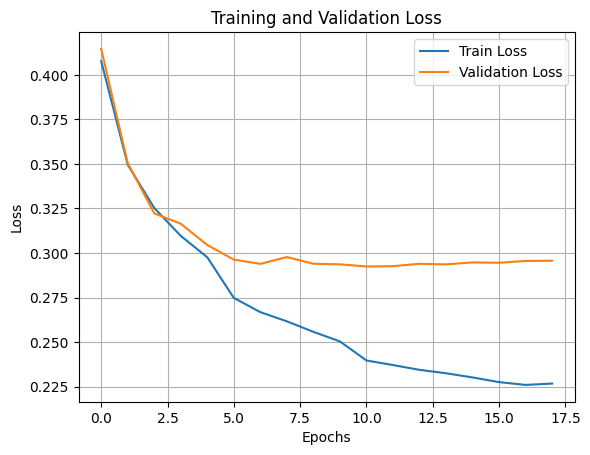

In [180]:
epochs = 18
tiny_mwt = TinyMWTConvNet('tinyMWT', dropout=0.1).to(device)

optimizer = torch.optim.Adam(tiny_mwt.parameters(), lr=4e-4)
sсheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma = 0.25)
loss = nn.BCELoss()
number_of_param = get_num_of_model_param(tiny_mwt)
print('number of model params:', number_of_param)

l1 = 0.1 / number_of_param
l2 = 0.2 / number_of_param
tiny_history = train(tiny_mwt, train_loader, val_loader, loss, epochs, optimizer, sсheduler, l1=l1, l2=l2)
visualize_history(tiny_history)

## MW&STFTNet

In [18]:
class MWSTFTNet(nn.Module):
    def __init__(self, name, dropout=0.0):
        super().__init__()
        self.name = name
        self.best_accuracy = 0
        self.STFT_extractor = TinySTFTConvExtractor(dropout=dropout)
        self.MWT_extractor = TinyMWTConvExtractor(dropout=dropout)
        self.classifier = nn.Sequential(
            nn.Linear(64 * 12 + 64 * 10, 150),
            nn.ELU(),
            nn.BatchNorm1d(150),
            nn.Linear(150, 64),
            nn.ELU(),
            nn.BatchNorm1d(64),
            nn.Linear(64, 6),
            nn.Softmax(dim=1)
        )
    
    def forward(self, x):
        mwt_mag = torch.from_numpy(np.abs(MorletTransform(x.to('cpu'))[0])).to(dtype).to(device)
        stft_mag = torch.from_numpy(np.abs(STFT(x.to('cpu'))[2])).to(dtype).to(device)

        mwt_features = self.MWT_extractor(mwt_mag)
        stft_features = self.STFT_extractor(stft_mag)
        all_features = torch.cat((mwt_features, stft_features), dim=1)
        result = self.classifier(all_features)
        return result

In [19]:
MWSTFT_model = MWSTFTNet('MWSTFT')

# Use pretrained models
tiny_stft_model = TinySTFTConvNet('MWSTFT_part')
tiny_stft_model.load_state_dict(torch.load(path_to_saved_weights + '/' + 'tinySTFT.pth'))
stft_extractor_wts = copy.deepcopy(tiny_stft_model.extractor.state_dict())
MWSTFT_model.STFT_extractor.load_state_dict(stft_extractor_wts)

tiny_MWT_model = TinyMWTConvNet('MWSTFT_part')
tiny_MWT_model.load_state_dict(torch.load(path_to_saved_weights + '/' + 'tinyMWT.pth'))
MWT_extractor_wts = copy.deepcopy(tiny_MWT_model.extractor.state_dict())
MWSTFT_model.MWT_extractor.load_state_dict(MWT_extractor_wts)

<All keys matched successfully>

number of model params: 613048
Start training
1 / 20 - val loss: 0.281492, accuracy: 0.606725
2 / 20 - val loss: 0.270251, accuracy: 0.617024
3 / 20 - val loss: 0.266776, accuracy: 0.616669
4 / 20 - val loss: 0.265417, accuracy: 0.618089
5 / 20 - val loss: 0.265107, accuracy: 0.617734
6 / 20 - val loss: 0.264592, accuracy: 0.618799
7 / 20 - val loss: 0.264584, accuracy: 0.620930
8 / 20 - val loss: 0.264624, accuracy: 0.620220
9 / 20 - val loss: 0.264707, accuracy: 0.619509
10 / 20 - val loss: 0.264806, accuracy: 0.620575
11 / 20 - val loss: 0.264816, accuracy: 0.619865
12 / 20 - val loss: 0.264827, accuracy: 0.620220
13 / 20 - val loss: 0.264844, accuracy: 0.620575
14 / 20 - val loss: 0.264866, accuracy: 0.620575
15 / 20 - val loss: 0.264891, accuracy: 0.620220
16 / 20 - val loss: 0.264898, accuracy: 0.620220
17 / 20 - val loss: 0.264904, accuracy: 0.620220
18 / 20 - val loss: 0.264911, accuracy: 0.620220
19 / 20 - val loss: 0.264918, accuracy: 0.619865
20 / 20 - val loss: 0.264925, ac

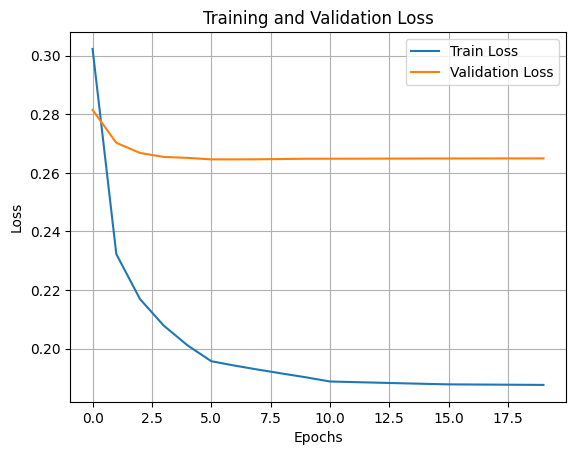

In [22]:
epochs = 20
freeze_moment = 10
MWSTFT_model = MWSTFT_model.to(device)
optimizer = torch.optim.Adam(MWSTFT_model.parameters(), lr=1e-5)
sсheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma = 0.25)
loss = nn.BCELoss()
number_of_param = get_num_of_model_param(MWSTFT_model)
print('number of model params:', number_of_param)

l1 = 0.1 / number_of_param
l2 = 0.2 / number_of_param
great_history = train(MWSTFT_model, train_loader, val_loader, loss, epochs, optimizer, sсheduler, l1=l1, l2=l2, freeze_moment=freeze_moment)
visualize_history(great_history)

In [25]:
result_loss, result_accuracy = evaluate_net(MWSTFT_model, test_loader, loss)
print('Result loss:', result_loss, '\nResult accuracy:', result_accuracy)

Result loss: 0.27375808053395967 
Result accuracy: 0.6161360347322721


We have got ~ 0.616 accuracy. Conclude something is not easy because this is cross-subject and cross-s
ession result. Now try to retrain model for one subject. Sorry for copypaste ;-(

In [44]:
directory_path = './Large EEG dataset/'
entries = os.listdir(directory_path)
event_duration = sampling_rate

subjA_data = []
subjA_markers = []
for entry in entries:
    full_path = os.path.join(directory_path, entry)
    if 'SubjectA' in full_path:
        if os.path.isfile(full_path):
            if '.mat' in full_path:
                data, markers = cut_all_imaginary_motion(full_path)
                subjA_data.append(data)
                subjA_markers.append(markers)
            
subjA_data = np.concatenate(subjA_data, axis=0)
subjA_data = np.transpose(subjA_data, (0, 2, 1))
subjA_markers = np.concatenate(subjA_markers, axis=0)
_ = gc.collect()

In [46]:
if subjA_data.shape[0] == subjA_markers.size:
    print('Dimensions are corresponding:', subjA_data.shape[0], 'imaginations in total')

Dimensions are corresponding: 2877 imaginations in total


Split and normalize

In [48]:
train_size = 0.75
test_size = 0.13
valid_size = 0.12

subjA_data_train, subjA_data_temp, subjA_markers_train, subjA_markers_temp = train_test_split(
    subjA_data, subjA_markers, train_size=train_size, stratify=subjA_markers, random_state=42)

subjA_data_test, subjA_data_valid, subjA_markers_test, subjA_markers_valid = train_test_split(
    subjA_data_temp, subjA_markers_temp, test_size=valid_size/(test_size + valid_size), stratify=subjA_markers_temp, random_state=42)

print("Size of train dataset:", len(subjA_data_train))
print("Size of test dataset:", len(subjA_data_test))
print("Size of valid dataset:", len(subjA_data_valid))

means = np.mean(subjA_data_train, axis=(0, 2), keepdims=True)
stds = np.std(subjA_data_train, axis=(0, 2), keepdims=True)
subjA_data_train = (subjA_data_train - means) / stds
subjA_data_test = (subjA_data_test - means) / stds
subjA_data_valid = (subjA_data_valid - means) / stds

Size of train dataset: 2157
Size of test dataset: 374
Size of valid dataset: 346


In [69]:
batch_size = 64
epochs = 10
class_num = 6
subjA_train_loader = create_dataloader(subjA_data_train, subjA_markers_train, batch_size)
subjA_val_loader = create_dataloader(subjA_data_valid, subjA_markers_valid, batch_size)
subjA_test_loader = create_dataloader(subjA_data_test, subjA_markers_test, batch_size)

number of model params: 613048
Start training
1 / 18 - val loss: 0.214793, accuracy: 0.716947
2 / 18 - val loss: 0.206250, accuracy: 0.718149
3 / 18 - val loss: 0.211784, accuracy: 0.730970
4 / 18 - val loss: 0.236283, accuracy: 0.706530
5 / 18 - val loss: 0.222389, accuracy: 0.697516
6 / 18 - val loss: 0.186930, accuracy: 0.779447
7 / 18 - val loss: 0.184272, accuracy: 0.744391
8 / 18 - val loss: 0.180655, accuracy: 0.742989
9 / 18 - val loss: 0.179785, accuracy: 0.749599
10 / 18 - val loss: 0.175668, accuracy: 0.759816
11 / 18 - val loss: 0.173268, accuracy: 0.798678
12 / 18 - val loss: 0.172049, accuracy: 0.805088
13 / 18 - val loss: 0.172979, accuracy: 0.798678
14 / 18 - val loss: 0.174583, accuracy: 0.796074
15 / 18 - val loss: 0.172276, accuracy: 0.800080
16 / 18 - val loss: 0.173185, accuracy: 0.791066
17 / 18 - val loss: 0.173377, accuracy: 0.803886
18 / 18 - val loss: 0.174007, accuracy: 0.798678


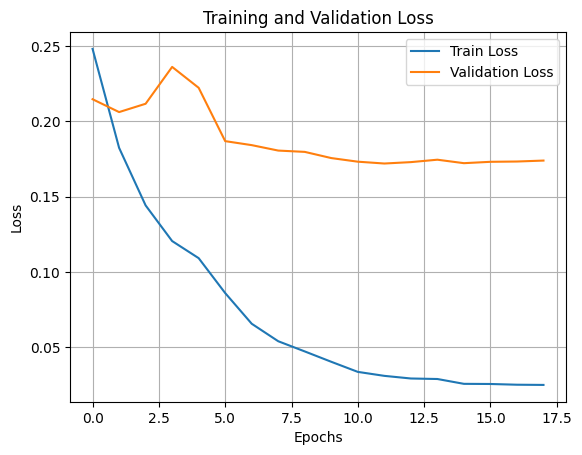

In [70]:
epochs = 18
subjA_MWSTFT_model = MWSTFTNet('subjA_MWSTFT', dropout=0.1).to(device)
subjA_MWSTFT_model.load_state_dict(torch.load(path_to_saved_weights + '/' + 'MWSTFT.pth'))

optimizer = torch.optim.Adam(subjA_MWSTFT_model.parameters(), lr=4e-4)
sсheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma = 0.25)
loss = nn.BCELoss()
number_of_param = get_num_of_model_param(subjA_MWSTFT_model)
print('number of model params:', number_of_param)

l1 = 0.1 / number_of_param
l2 = 0.2 / number_of_param
subjA_history = train(subjA_MWSTFT_model, subjA_train_loader, subjA_val_loader, loss, epochs, 
                      optimizer, sсheduler, l1=l1, l2=l2)
visualize_history(subjA_history)

In [71]:
subj_A_loss, subj_A_accuracy = evaluate_net(subjA_MWSTFT_model, subjA_test_loader, loss)
print('Result loss:', subj_A_loss, '\nResult accuracy:', subj_A_accuracy)

Result loss: 0.20289372156063715 
Result accuracy: 0.7459893048128342


In [72]:
del subjA_MWSTFT_model, subjA_train_loader, subj_A_accuracy

It appears that it is better to use pretrained weights. Without use result loss: 0.2231, rResult accuracy 0.7112. With use pretrained weights: result loss 0.20289, rResult accuracy: 0.7459832

Now do retrain and evaluation for all other subgects.

In [86]:
subjects_list = ['A', 'B', 'C', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M']
test_losses = []
test_accuracies = []

train_size = 0.75
test_size = 0.13
valid_size = 0.12

for subject_letter in subjects_list:
    # sry for copepaste ;-(
    directory_path = './Large EEG dataset/'
    entries = os.listdir(directory_path)
    event_duration = sampling_rate
    all_data = []
    all_markers = []
    for entry in entries:
        full_path = os.path.join(directory_path, entry)
        if 'Subject' + subject_letter in full_path:
            if os.path.isfile(full_path):
                if '.mat' in full_path:
                    data, markers = cut_all_imaginary_motion(full_path)
                    all_data.append(data)
                    all_markers.append(markers)
                
    data = np.concatenate(all_data, axis=0)
    data = np.transpose(data, (0, 2, 1))
    markers = np.concatenate(all_markers, axis=0)
    _ = gc.collect()

    data_train, data_temp, markers_train, markers_temp = train_test_split(
    data, markers, train_size=train_size, stratify=markers, random_state=42)

    data_test, data_valid, markers_test, markers_valid = train_test_split(
        data_temp, markers_temp, test_size=valid_size/(test_size + valid_size), 
        stratify=markers_temp, random_state=42)

    means = np.mean(data_train, axis=(0, 2), keepdims=True)
    stds = np.std(data_train, axis=(0, 2), keepdims=True)
    data_train = (data_train - means) / stds
    data_test = (data_test - means) / stds
    data_valid = (data_valid - means) / stds

    batch_size = 64
    epochs = 18
    class_num = 6
    train_loader = create_dataloader(data_train, markers_train, batch_size)
    val_loader = create_dataloader(data_valid, markers_valid, batch_size)
    test_loader = create_dataloader(data_test, markers_test, batch_size)

    
    MWSTFT_model = MWSTFTNet('subj', dropout=0.1).to(device)
    MWSTFT_model.load_state_dict(torch.load(path_to_saved_weights + '/' + 'MWSTFT.pth'))
    
    optimizer = torch.optim.Adam(MWSTFT_model.parameters(), lr=4e-4)
    sсheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma = 0.25)
    loss = nn.BCELoss()
    number_of_param = get_num_of_model_param(MWSTFT_model)
    
    l1 = 0.1 / number_of_param
    l2 = 0.2 / number_of_param
    history = train(MWSTFT_model, train_loader, val_loader, loss, epochs, 
                          optimizer, sсheduler, l1=l1, l2=l2, output=False)
    test_loss, test_accuracy = evaluate_net(MWSTFT_model, test_loader, loss)
    print('Subject ' + subject_letter + ' test loss:', test_loss, 'test accuracy:', test_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

Subject A test loss: 0.21837874501943588 test accuracy: 0.7433155080213903
Subject B test loss: 0.34353875120480853 test accuracy: 0.46112600536193027
Subject C test loss: 0.1554262451827526 test accuracy: 0.7951807228915663
Subject E test loss: 0.20145894587039948 test accuracy: 0.77088948787062
Subject F test loss: 0.287550650537014 test accuracy: 0.6390374331550802
Subject G test loss: 0.18082271267970404 test accuracy: 0.7795698924731183
Subject H test loss: 0.3936905637383461 test accuracy: 0.45161290322580644
Subject I test loss: 0.40360480546951294 test accuracy: 0.3739495798319328
Subject J test loss: 0.03275151550769806 test accuracy: 0.975609756097561
Subject K test loss: 0.2549348697066307 test accuracy: 0.6867469879518072
Subject L test loss: 0.09872029535472393 test accuracy: 0.8785425101214575
Subject M test loss: 0.1971819375952085 test accuracy: 0.760752688172043


In [92]:
print('Test losses:')
print(["{:.3f}".format(loss) for loss in test_losses])
print('Test accuracies:')
print(["{:.3f}".format(accuracy) for accuracy in test_accuracies])
print('Mean test loss:', np.mean(test_losses))
print('Mean test accuracy:', np.mean(test_accuracies))
print('Median test accuracy:', np.median(test_accuracies))
print('Minimum test accuracy:', np.min(test_accuracies))
print('Maximum test accuracy:', np.max(test_accuracies))

Test losses:
['0.218', '0.344', '0.155', '0.201', '0.288', '0.181', '0.394', '0.404', '0.033', '0.255', '0.099', '0.197']
Test accuracies:
['0.743', '0.461', '0.795', '0.771', '0.639', '0.780', '0.452', '0.374', '0.976', '0.687', '0.879', '0.761']
Mean test loss: 0.23067166982218626
Mean test accuracy: 0.6930277895978594
Median test accuracy: 0.7520340980967166
Minimum test accuracy: 0.3739495798319328
Maximum test accuracy: 0.975609756097561


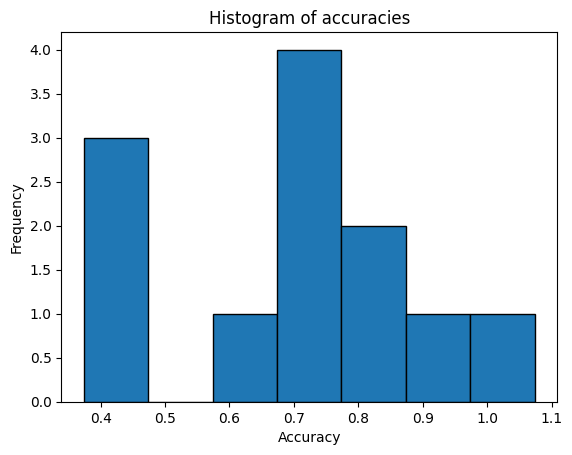

In [91]:
accuracy = np.array(test_accuracies)
step = 0.1

bins = np.arange(min(accuracy), max(accuracy) + step, step)

plt.hist(accuracy, bins=bins, edgecolor='black')
plt.title('Histogram of accuracies')
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.show()

# Conclucion

So, writen DL model thath use STFT and MWT, time-convolutions and frequency-convolution, fully-connected layers shows ~0.62 accuracy at cross-subject and cross-session records. Weights of this model was used to retrain models for each subject cross-session and calculate accuracies. Mean accuracy (across subjects) turned out to be ~0.69. It should be noted that accuracy highly depends on subject. So other statistics was calculated (you can see hisogram above):
Mean accuracy: 0.6930
Mediat accuracy: 0.7526
Minimst accuracy: 0.3728
Maximst accuracy: 0.9
Obviously, every person has unique brain structure and not everyone can easy handle with keeping attention all the time. So cross-subject differences turned out high.561